# Shoplifting Detection from CCTV Videos
This notebook tackles the problem of detecting shoplifting activities from video footage. We will load a dataset of videos, preprocess them, and explore different deep learning models for classification.

Goal: Classify a video as either containing 'Shoplifting' or 'No Shoplifting'.

# 1. Setup and Imports
First, let's import all the necessary libraries. We'll need OpenCV for video processing, NumPy for numerical operations, TensorFlow/Keras for building our models, and matplotlib for visualization.

In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import TimeDistributed, LSTM, GRU, ConvLSTM2D, Input, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2, EfficientNetV2B0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, AUC

print("Libraries Imported!")

Libraries Imported!


# 2. Data Loading and Preprocessing
Our dataset is in two folders We need to:
- Read each video file.
- Extract a fixed number of frames from each video. Processing entire videos is computationally expensive, so we'll sample frames.
- Resize frames to a consistent dimension.
- Assign a label: 1 for Shoplifting, 0 for No Shoplifting.

- 70% of frames will be taken from the middle 50% of the video.

- 30% of frames will be taken from the beginning and end sections.

This ensures our model sees the context (start and end) but focuses its attention on the most critical part of the video where the action happens.

In [2]:
# --- Configuration ---
IMG_SIZE = 128  # Resize frames to 128x128
MAX_FRAMES = 20 # Use a fixed number of frames from each video
DATASET_PATH = "/kaggle/input/shoplifting-videos-dataset/Shop DataSet"

# --- Define folder paths ---
SHOPLIFTING_PATH = os.path.join(DATASET_PATH, "shop lifters")
NO_SHOPLIFTING_PATH = os.path.join(DATASET_PATH, "non shop lifters")

# --- UPDATED Data loading function with Biased Sampling ---
def load_videos(folder_path, label):
    """
    Loads videos, extracts frames with a bias towards the middle, and assigns a label.
    """
    video_files = os.listdir(folder_path)
    sequences = []
    labels = []
    
    print(f"Processing folder: {folder_path}")
    for video_file in video_files:
        video_path = os.path.join(folder_path, video_file)
        cap = cv2.VideoCapture(video_path)
        
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Skip videos that are too short to sample from
        if total_frames < MAX_FRAMES:
            cap.release()
            continue

        frames = []
        
        # --- Biased Frame Sampling Logic ---
        # Define how many frames to take from the middle vs. edges
        n_frames_middle = int(MAX_FRAMES * 0.7)  # e.g., 14 frames
        n_frames_edges = MAX_FRAMES - n_frames_middle # e.g., 6 frames

        # Define the video sections
        middle_start_frame = int(total_frames * 0.25)
        middle_end_frame = int(total_frames * 0.75)

        # Generate indices for frames to extract
        middle_indices = np.linspace(middle_start_frame, middle_end_frame, n_frames_middle, dtype=int)
        edge_indices_start = np.linspace(0, middle_start_frame - 1, n_frames_edges // 2, dtype=int)
        edge_indices_end = np.linspace(middle_end_frame + 1, total_frames - 1, n_frames_edges - (n_frames_edges // 2), dtype=int)
        
        # Combine indices, ensure they are unique and sorted
        combined_indices = np.concatenate([edge_indices_start, middle_indices, edge_indices_end])
        unique_indices = np.unique(combined_indices)
        unique_indices.sort()

        # Extract the frames at the calculated indices
        for frame_idx in unique_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
                frames.append(frame)
        
        cap.release()

        # --- Padding / Truncating to ensure fixed length ---
        # Ensure every sequence has exactly MAX_FRAMES
        if len(frames) > MAX_FRAMES:
            frames = frames[:MAX_FRAMES]
        elif len(frames) < MAX_FRAMES and len(frames) > 0:
            # Pad with the last frame if we have too few
            padding = [frames[-1]] * (MAX_FRAMES - len(frames))
            frames.extend(padding)

        if len(frames) == MAX_FRAMES:
            sequences.append(np.array(frames))
            labels.append(label)
            
    return sequences, labels

# --- Load the data ---
print("Loading 'Shoplifting' videos...")
shoplifting_sequences, shoplifting_labels = load_videos(SHOPLIFTING_PATH, 1)
print(f"Loaded {len(shoplifting_sequences)} shoplifting videos.")

print("\nLoading 'No Shoplifting' videos...")
no_shoplifting_sequences, no_shoplifting_labels = load_videos(NO_SHOPLIFTING_PATH, 0)
print(f"Loaded {len(no_shoplifting_sequences)} 'no shoplifting' videos.")

# --- Combine and prepare the final dataset ---
X = np.array(shoplifting_sequences + no_shoplifting_sequences)
y = np.array(shoplifting_labels + no_shoplifting_labels)

# Normalize pixel values to be between 0 and 1
X = X / 255.0

print(f"\nFinal dataset shape (Videos, Frames, Height, Width, Channels): {X.shape}")
print(f"Final labels shape: {y.shape}")

# --- Split into training and testing sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Loading 'Shoplifting' videos...
Processing folder: /kaggle/input/shoplifting-videos-dataset/Shop DataSet/shop lifters
Loaded 324 shoplifting videos.

Loading 'No Shoplifting' videos...
Processing folder: /kaggle/input/shoplifting-videos-dataset/Shop DataSet/non shop lifters
Loaded 531 'no shoplifting' videos.

Final dataset shape (Videos, Frames, Height, Width, Channels): (855, 20, 128, 128, 3)
Final labels shape: (855,)

Training data shape: (684, 20, 128, 128, 3)
Testing data shape: (171, 20, 128, 128, 3)


## Data Visualization

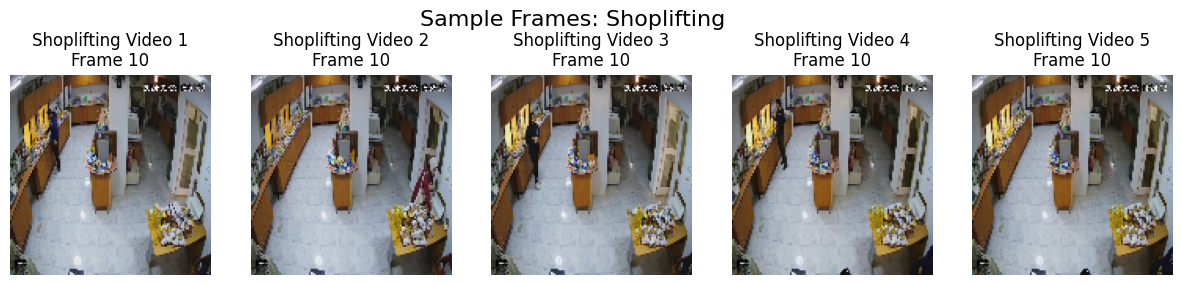

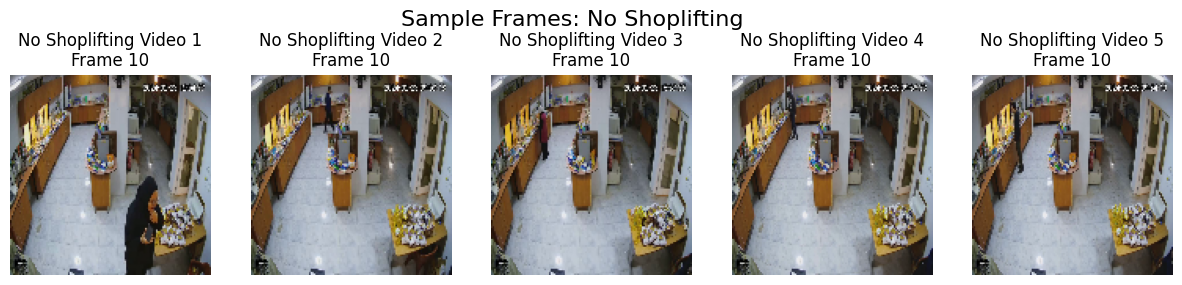

In [3]:
def plot_sample_frames(X, y, class_name):
    """Plots sample frames for a given class."""
    plt.figure(figsize=(15, 6))
    class_indices = np.where(y == (1 if class_name == "Shoplifting" else 0))[0]
    
    for i, idx in enumerate(class_indices[:5]): # Show first 5 videos of the class
        video = X[idx]
        # Show the 10th frame of the video
        frame = video[10] 
        plt.subplot(2, 5, i + 1)
        plt.imshow(frame)
        plt.title(f"{class_name} Video {i+1}\nFrame 10")
        plt.axis('off')

    plt.suptitle(f"Sample Frames: {class_name}", fontsize=16)
    plt.show()

# Visualize some training samples
plot_sample_frames(X_train, y_train, "Shoplifting")

plot_sample_frames(X_train, y_train, "No Shoplifting")

# 3. Model Suggestions
## Model 1: 3DCNN Architecture

In [ ]:


input_shape = (MAX_FRAMES,IMG_SIZE, IMG_SIZE, 3)

conv3d_model = Sequential([
    Conv3D(32, (3, 3, 3), activation='relu', input_shape=input_shape),
    MaxPooling3D(pool_size=(1, 2, 2)),
    BatchNormalization(),

    Conv3D(64, (3, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    BatchNormalization(),

    Conv3D(128, (3, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

conv3d_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])
conv3d_model.summary()

### Training The 3D Conv Model

In [5]:
history_3d = conv3d_model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=10,
          batch_size=8,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])


86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0039 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0035 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 9/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0037 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 4.6416e-04 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 10/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0082 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 5.5689e-04 - val_precision: 1.0000 - val_recall: 1.0000


### Visualizing results of 3D Conv Model

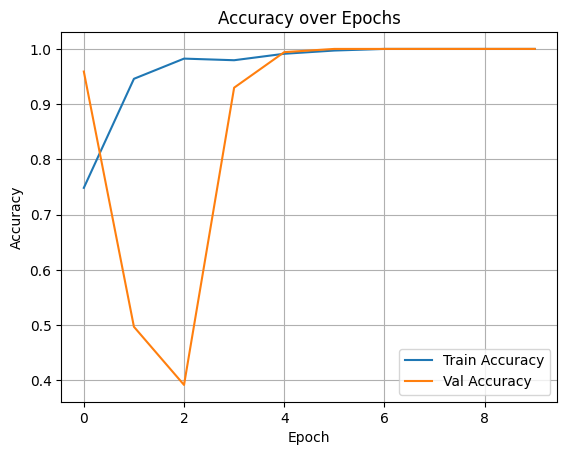

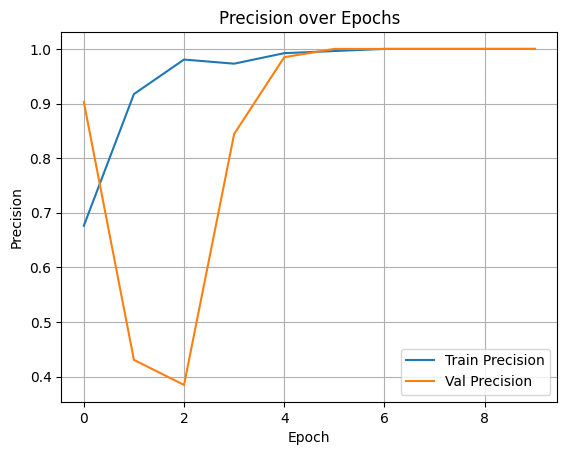

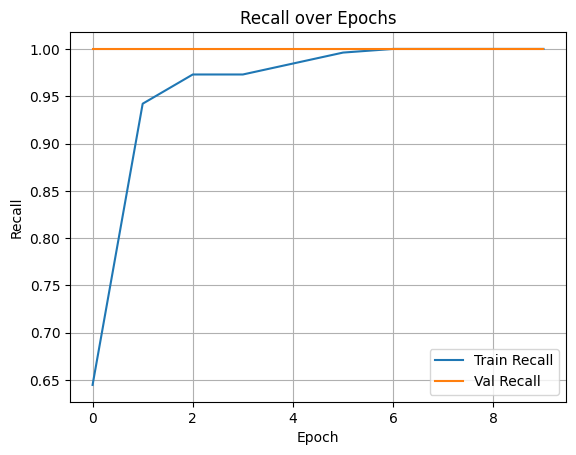

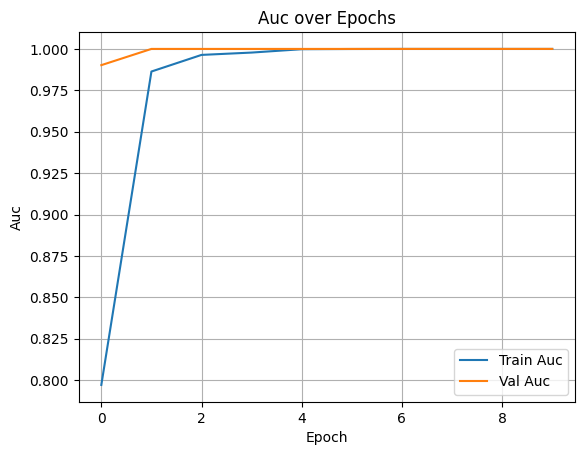

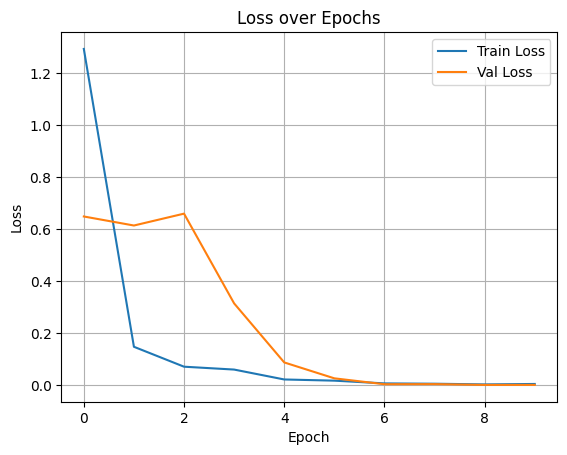

In [6]:

def plot_training_history(history):
    metrics = ['accuracy', 'precision', 'recall', 'auc', 'loss']
    for metric in metrics:
        train_metric = history.history.get(metric)
        val_metric = history.history.get(f'val_{metric}')

        if train_metric is not None:
            plt.figure()
            plt.plot(train_metric, label=f'Train {metric.capitalize()}')
            if val_metric is not None:
                plt.plot(val_metric, label=f'Val {metric.capitalize()}')
            plt.xlabel('Epoch')
            plt.ylabel(metric.capitalize())
            plt.title(f'{metric.capitalize()} over Epochs')
            plt.legend()
            plt.grid(True)
            plt.show()
plot_training_history(history_3d)

### Model 2 : Pretrained CNN + LSTM

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization


def build_cnn_plus_lstm_model():
    input_shape = (MAX_FRAMES,IMG_SIZE, IMG_SIZE, 3)
    input_layer= Input(shape=input_shape)

    cnn_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    for layer in cnn_base.layers:
        layer.trainable=False
        
    cnn_out = TimeDistributed(cnn_base)(input_layer)
    cnn_out = TimeDistributed(GlobalAveragePooling2D())(cnn_out)
    cnn_out = TimeDistributed(BatchNormalization())(cnn_out)

    lstm_out = LSTM(128, return_sequences=False)(cnn_out)
    x = Dropout(0.5)(lstm_out)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output)

    return model

In [8]:
lstm_model = build_cnn_plus_lstm_model()
lstm_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 20, 128, 128,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 4, 4, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 1280)       │         5,120 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       721,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,992,833 (11.42 MB)

 Trainable params: 732,289 (2.79 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

### Training the CNN + LSTM Model

In [9]:
lstm_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

history_lstm = lstm_model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=10,
          batch_size=4,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 169s 332ms/step - accuracy: 0.7072 - auc_1: 0.7591 - loss: 0.5742 - precision_1: 0.6343 - recall_1: 0.4659 - val_accuracy: 0.9240 - val_auc_1: 0.9851 - val_loss: 0.2913 - val_precision_1: 0.9333 - val_recall_1: 0.8615
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - accuracy: 0.8849 - auc_1: 0.9549 - loss: 0.3477 - precision_1: 0.8823 - recall_1: 0.8145 - val_accuracy: 0.9942 - val_auc_1: 1.0000 - val_loss: 0.1609 - val_precision_1: 1.0000 - val_recall_1: 0.9846
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - accuracy: 0.9144 - auc_1: 0.9689 - loss: 0.2680 - precision_1: 0.9092 - recall_1: 0.8771 - val_accuracy: 1.0000 - val_auc_1: 1.0000 - val_loss: 0.0986 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 23s 136ms/step - accuracy: 0.9486 - auc_1: 0.9832 - loss: 0.1771 - precision_1: 0.9445 - recall_1: 0.9112 - val_accuracy: 1.0000 - val_auc_1: 1.0000 - val_loss: 0.0664 - val_precision_1: 1

### Visualizing The Result Of the Model

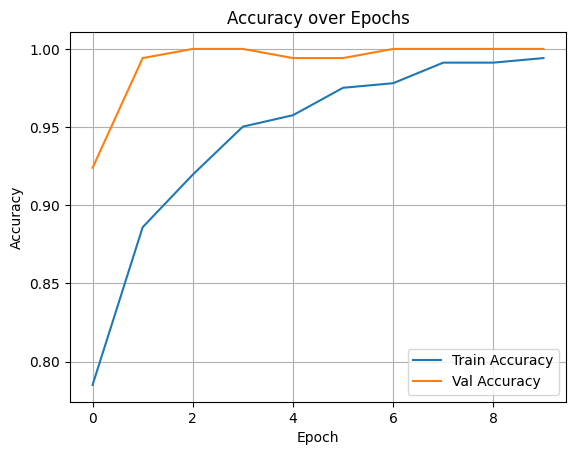

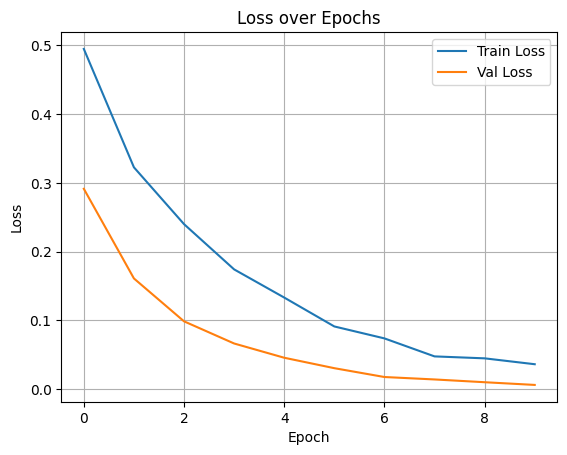

In [10]:
plot_training_history(history_lstm)

### Model 3: Transformer

In [11]:
from tensorflow.keras.layers import (
    Input, TimeDistributed, Dense, Dropout, GlobalAveragePooling2D,
    LayerNormalization, MultiHeadAttention, Add
)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attention = Dropout(dropout)(attention)
    x = Add()([inputs, attention])
    x = LayerNormalization(epsilon=1e-6)(x)

    ff = Dense(ff_dim, activation='relu')(x)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1])(ff)
    x = Add()([x, ff])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

def build_cnn_plus_transformer():
    input_shape = (MAX_FRAMES, IMG_SIZE, IMG_SIZE, 3)
    input_layer = Input(shape=input_shape)

    cnn_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    cnn_base.trainable = False

    x = TimeDistributed(cnn_base)(input_layer)
    x = TimeDistributed(GlobalAveragePooling2D())(x)

    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output)
    return model

In [12]:
transformer_model = build_cnn_plus_transformer()
transformer_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 20, 128,   │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 20, 4, 4,  │  2,257,984 │ input_layer_3[0]… │
│ (TimeDistributed)   │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 20, 1280)  │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 1280)  │  1,312,768 │ time_distributed… │
│ (MultiHeadAttentio… │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 20, 1280)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 20, 1280)  │          0 │ time_distributed… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 20, 1280)  │      2,560 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 20, 128)   │    163,968 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 20, 128)   │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 20, 1280)  │    165,120 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 20, 1280)  │          0 │ layer_normalizat… │
│                     │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 1280)  │      2,560 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │     81,984 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         65 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,987,009 (15.21 MB)

 Trainable params: 1,729,025 (6.60 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:

transformer_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

history_transformer = transformer_model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=10,
          batch_size=4,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 203s 402ms/step - accuracy: 0.6797 - auc_2: 0.6827 - loss: 0.6084 - precision_2: 0.6093 - recall_2: 0.4438 - val_accuracy: 0.9240 - val_auc_2: 0.9719 - val_loss: 0.2114 - val_precision_2: 0.8714 - val_recall_2: 0.9385
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.9077 - auc_2: 0.9569 - loss: 0.2440 - precision_2: 0.8531 - recall_2: 0.9079 - val_accuracy: 0.9649 - val_auc_2: 0.9983 - val_loss: 0.1022 - val_precision_2: 1.0000 - val_recall_2: 0.9077
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.9716 - auc_2: 0.9880 - loss: 0.0965 - precision_2: 0.9489 - recall_2: 0.9663 - val_accuracy: 0.9532 - val_auc_2: 0.9989 - val_loss: 0.1330 - val_precision_2: 0.8904 - val_recall_2: 1.0000
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.9694 - auc_2: 0.9966 - loss: 0.0711 - precision_2: 0.9432 - recall_2: 0.9826 - val_accuracy: 0.9825 - val_auc_2: 0.9999 - val_loss: 0.0437 - val_precision_2: 0.95

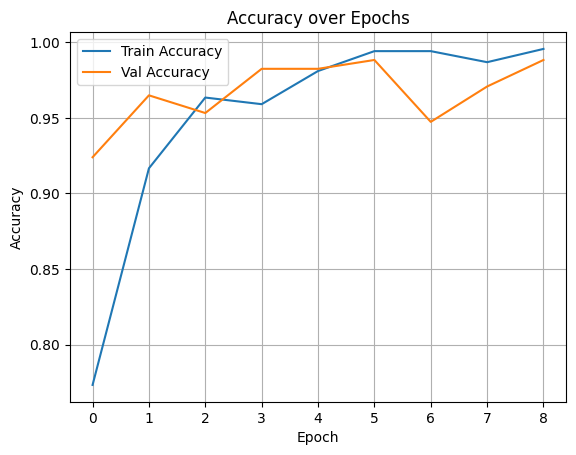

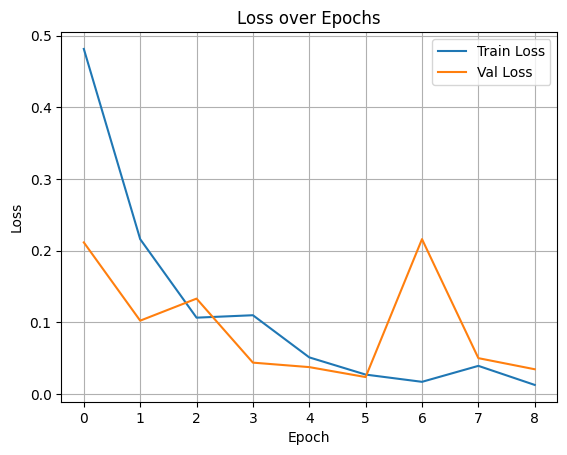

In [14]:
plot_training_history(history_transformer)

In [15]:
from tensorflow.keras import backend as K
import gc

# After finishing with your model
K.clear_session()
del transformer_model
gc.collect()

0

### More pretrained models

In [16]:
def build_cnn_plus_lstm_model(input_shape = (MAX_FRAMES, IMG_SIZE, IMG_SIZE, 3)):
    # Define the input layer
    input_layer = Input(shape=input_shape, name="input_layer")

    # 1. Spatial Feature Extraction (CNN)
    # Load MobileNetV2, pre-trained on ImageNet, without its final classifier
    cnn_base = MobileNetV2(weights='imagenet', include_top=False, 
                           input_shape=input_shape[1:]) # Shape of a single frame
    
    # Freeze the layers of the pre-trained base
    cnn_base.trainable = False
    
    # Apply the CNN to each frame of the video sequence
    # The output is a sequence of feature maps
    cnn_out = TimeDistributed(cnn_base, name="mobilenet_feature_extractor")(input_layer)
    
    # Flatten the spatial features for each frame into a single vector
    cnn_out = TimeDistributed(GlobalAveragePooling2D(), name="feature_vector_pooling")(cnn_out)

    # 2. Temporal Feature Processing (RNN)
    # The LSTM processes the sequence of feature vectors
    lstm_out = LSTM(128, return_sequences=False, name="lstm_temporal_processor")(cnn_out)
    
    # 3. Classifier Head
    x = Dropout(0.5)(lstm_out)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='sigmoid', name="output_layer")(x)

    # Create the final model
    model = Model(inputs=input_layer, outputs=output, name="MobileNetV2_plus_LSTM")

    return model

In [17]:
cnn_lstm_model = build_cnn_plus_lstm_model()
cnn_lstm_model.summary()

Model: "MobileNetV2_plus_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 128, 128,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_feature_extractor     │ (None, 20, 4, 4, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_vector_pooling          │ (None, 20, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_temporal_processor (LSTM)  │ (None, 128)            │       721,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,987,713 (11.40 MB)

 Trainable params: 729,729 (2.78 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:

cnn_lstm_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

history_cnn_lstm = cnn_lstm_model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=10,
          batch_size=4,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 161s 336ms/step - accuracy: 0.6132 - auc: 0.6331 - loss: 0.6545 - precision: 0.5354 - recall: 0.3989 - val_accuracy: 0.8480 - val_auc: 0.9484 - val_loss: 0.3253 - val_precision: 0.8305 - val_recall: 0.7538
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 23s 136ms/step - accuracy: 0.9067 - auc: 0.9267 - loss: 0.3085 - precision: 0.8315 - recall: 0.8892 - val_accuracy: 0.9474 - val_auc: 0.9909 - val_loss: 0.1443 - val_precision: 0.8889 - val_recall: 0.9846
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 23s 136ms/step - accuracy: 0.9201 - auc: 0.9820 - loss: 0.1794 - precision: 0.8676 - recall: 0.9224 - val_accuracy: 0.9474 - val_auc: 0.9987 - val_loss: 0.1158 - val_precision: 1.0000 - val_recall: 0.8615
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.9669 - auc: 0.9879 - loss: 0.1191 - precision: 0.9459 - recall: 0.9547 - val_accuracy: 0.9532 - val_auc: 0.9879 - val_loss: 0.1645 - val_precision: 0.8904 - val_recall: 1.0000
Epoch 5/10
171/171 

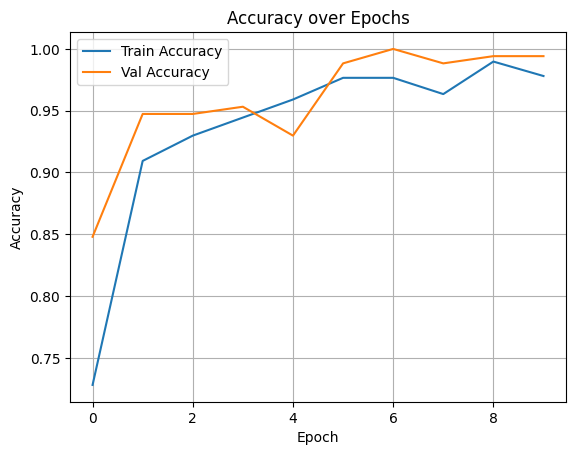

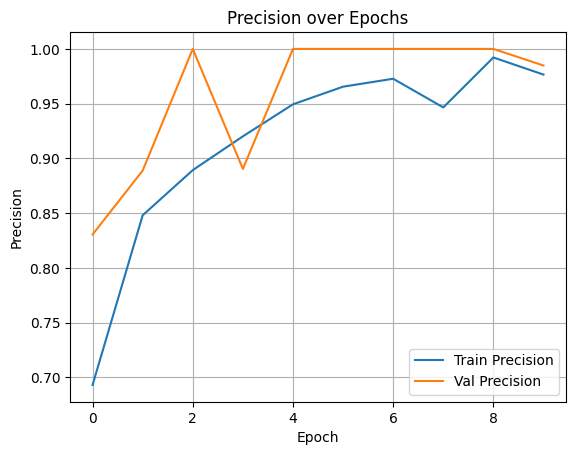

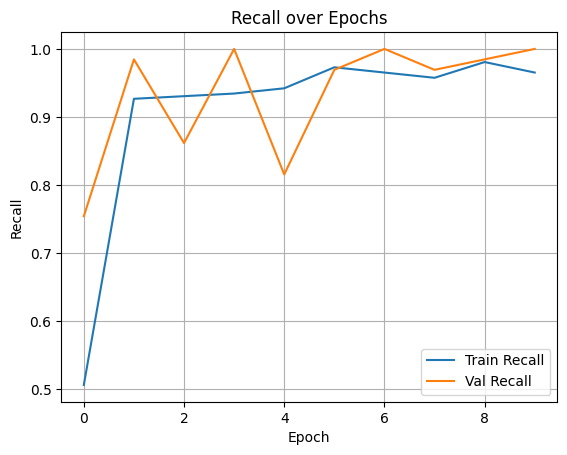

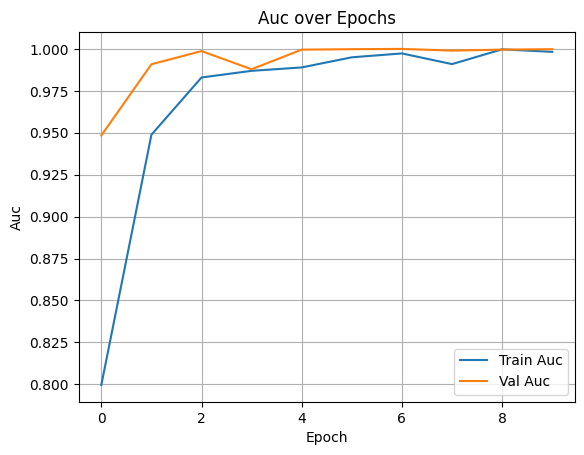

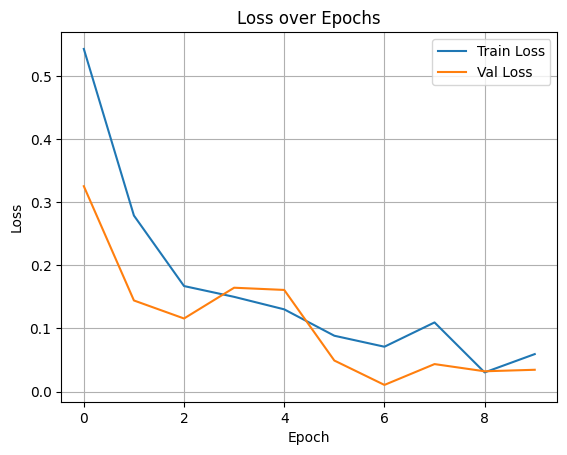

In [19]:
plot_training_history(history_cnn_lstm)

In [20]:
from tensorflow.keras import backend as K
import gc

# After finishing with your model
K.clear_session()
del cnn_lstm_model
gc.collect()


0

In [4]:
def build_efficientnet_plus_gru_model(input_shape = (MAX_FRAMES, IMG_SIZE, IMG_SIZE, 3)):
    # Define the input layer
    input_layer = Input(shape=input_shape, name="input_layer")

    # 1. Spatial Feature Extraction (CNN)
    # Load EfficientNetV2B0, pre-trained on ImageNet
    cnn_base = EfficientNetV2B0(weights='imagenet', include_top=False, 
                                input_shape=input_shape[1:])
    
    # Freeze the layers of the pre-trained base
    cnn_base.trainable = False
    
    # Apply the CNN to each frame of the video sequence
    cnn_out = TimeDistributed(cnn_base, name="efficientnet_feature_extractor")(input_layer)
    
    # Flatten the spatial features for each frame
    cnn_out = TimeDistributed(GlobalAveragePooling2D(), name="feature_vector_pooling")(cnn_out)

    # 2. Temporal Feature Processing (RNN)
    # The GRU processes the sequence of feature vectors
    gru_out = GRU(128, return_sequences=False, name="gru_temporal_processor")(cnn_out)
    
    # 3. Classifier Head
    x = Dropout(0.5)(gru_out)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='sigmoid', name="output_layer")(x)

    # Create the final model
    model = Model(inputs=input_layer, outputs=output, name="EfficientNetV2_plus_GRU")

    return model

In [5]:
efficientnet_gru_model = build_efficientnet_plus_gru_model()
efficientnet_gru_model.summary()

I0000 00:00:1755304632.308471      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "EfficientNetV2_plus_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 128, 128,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet_feature_extractor  │ (None, 20, 4, 4, 1280) │     5,919,312 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_vector_pooling          │ (None, 20, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_temporal_processor (GRU)    │ (None, 128)            │       541,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,469,073 (24.68 MB)

 Trainable params: 549,761 (2.10 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [10]:

efficientnet_gru_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

history_efficientnet_gru = efficientnet_gru_model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=10,
          batch_size=4,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/10


E0000 00:00:1755304996.152560      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/EfficientNetV2_plus_GRU_1/efficientnet_feature_extractor_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1755305012.623969    3523 cuda_dnn.cc:529] Loaded cuDNN version 90300


171/171 ━━━━━━━━━━━━━━━━━━━━ 412s 687ms/step - accuracy: 0.5985 - auc: 0.4595 - loss: 0.6749 - precision: 0.0624 - recall: 0.0117 - val_accuracy: 0.6199 - val_auc: 0.5000 - val_loss: 0.6788 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 37s 214ms/step - accuracy: 0.5973 - auc: 0.5059 - loss: 0.6837 - precision: 0.4792 - recall: 0.1631 - val_accuracy: 0.6199 - val_auc: 0.5000 - val_loss: 0.6647 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 36s 212ms/step - accuracy: 0.5886 - auc: 0.4727 - loss: 0.6855 - precision: 0.3148 - recall: 0.0536 - val_accuracy: 0.6199 - val_auc: 0.5000 - val_loss: 0.6654 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 37s 214ms/step - accuracy: 0.6136 - auc: 0.4832 - loss: 0.6652 - precision: 0.2599 - recall: 0.0599 - val_accuracy: 0.6199 - val_auc: 0.5000 - val_loss: 0.6653 - val_precision: 0.0000e+00 - val_recall: 0.0000e+0

In [ ]:
plot_training_history(history_efficientnet_gru)

# 4. Saving Models

In [ ]:
conv3d_model.save('conv3d.h5')
lstm_model.save('lstm_model.h5')
transformer_model.save('transformer_model.h5')
cnn_lstm_model.save('cnn_lstm_model.h5')
efficientnet_gru_model.save('efficientnet_gru_model.h5')